# Use Streams Designer to classify newsgroup topics using an LDA model
Part 2 of 2
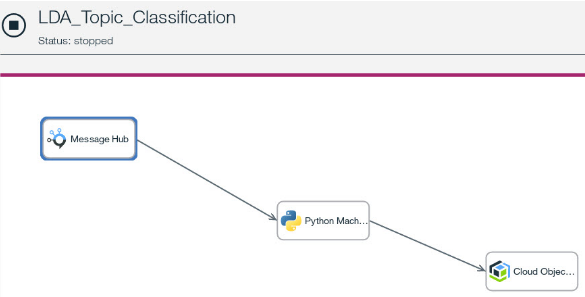
## Introduction
This is part 2 of this tutorial notebook series.  
In [part 1](https://dataplatform.ibm.com/analytics/notebooks/v2/24ca198f-bf20-4d51-b027-38017c2b94dc/view?access_token=e06a09d39b959bac9dc22782a25ba173681e8d175168bfbfc7f88065ca673a55), we created an LDA model and saved it on __Bluemix Cloud Object Storage__.

In this tutorial notebook, you will be taught how to import a sample __Streams flow__ into __Bluemix Streams Designer__. The _flow_ will use the LDA model to perform real-time topic classification on news items arriving from __Bluemix Message Hub__ and store the results on __Bluemix Cloud Object Storage__.  

Once the _Streams flow_ is up and running, we will continue in this notebook to stream the news items to __Bluemix Message Hub__ so that they can be picked up by the flow.

Some familiarity with Python is recommended. This notebook has been verified for Python 3.5 and Spark 2.1.

## <a id="TOC"></a> Table of contents
1. [Setup](#setup)<br>
    1.1 [Install prerequisite packages](#setup1)<br>
    1.2 [[Optional] Copy a sample LDA model package to Cloud Object Storage (COS)](#setup2)<br>
    1.3 [Provide Credentials for Message Hub](#setup3)<br>
    1.4 [Provide a Message Hub (MH) Topic name](#setup4)<br>
    1.5 [Download the sample topic classification _Streams Flow_](#setup5)<br>
    1.6 [Download the sample dataset](#setup6)<br>
2. [Define functions](#define)<br>
    2.1 [function: read_dataset](#define1)<br>
    2.2 [function: create_messagehub_producer](#define2)<br>
3. [Create a Streams Flow using DSX Streams Designer](#flow)<br>
4. [Stream the news texts to Message Hub](#send)<br>
5. [Summary and next steps](#summary)<br>

<a id="setup"></a>
## 1. [Setup](#TOC)
The _Streams Flow_ which you will create in this tutorial will require you to provision the following __Bluemix__ services:
* __Streaming Analytics__: The service should be started, although this can also be done from _Streams Designer_.
* __Message Hub__: Create a topic to use for the flow, for example, _newsData_.
* __Cloud Object Storage__: 
    - Create a bucket to store the LDA model package (you should have done this in part 1), for example, **_pyml_**.
    - Create a bucket to store the output of the topic classification, for example, **_pyml-output_**.

<a id="setup1"></a>
### 1.1 [Install prerequisite packages](#TOC)
Make sure that these packages are installed.

In [ ]:
!pip install --user kafka

<a id="setup2"></a>
### 1.2 [[Optional] Copy a sample LDA model package to Cloud Object Storage (COS)](#TOC)
If you saved an LDA model package to COS in [part 1](https://dataplatform.ibm.com/analytics/notebooks/v2/24ca198f-bf20-4d51-b027-38017c2b94dc/view?access_token=e06a09d39b959bac9dc22782a25ba173681e8d175168bfbfc7f88065ca673a55) of this tutorial series, [skip this step](#setup2).  
If you did **NOT** create your own LDA model, you can download this sample model package **<!>LDA_news.model.pkg.gz** and upload it to a bucket in your __Bluemix Cloud Object Storage__ service.

__Note__ the bucket name where your model package is stored.

<a id="setup3"></a>
### 1.3 [Provide Credentials for Message Hub (MH)](#TOC)
The MH credentials will be used at the end of this tutorial for streaming news text to the _Streams Flow_.

You can copy your __Message Hub__ `Service credentials` from the __IBM Cloud Dashboard__.

You can replace the entire value of the **mh_credentials** variable with your credentials, or at least provide values for <font color=blue>'user'</font> and <font color=blue>'password'</font>.  
Make sure that the <font color=red>_name_</font> of the credentials variable is set to **mh_credentials**.

**<!erase credentials>**

In [ ]:
# INSERT YOUR MESSAGE HUB CREDENTIALS
mh_credentials = {
    "user": "<REPLACE>",
    "password": "<REPLACE>"
}
# m9
mh_credentials = {
  "instance_id": "b32d208f-fbdb-425c-95d3-5b00b56209c4",
  "mqlight_lookup_url": "https://mqlight-lookup-prod02.messagehub.services.us-south.bluemix.net/Lookup?serviceId=b32d208f-fbdb-425c-95d3-5b00b56209c4",
  "api_key": "u4cbPZKOoOHI9uZ5J66JaZBtOF2cRVPYu4UEAG7PXIn4SleB",
  "kafka_admin_url": "https://kafka-admin-prod02.messagehub.services.us-south.bluemix.net:443",
  "kafka_rest_url": "https://kafka-rest-prod02.messagehub.services.us-south.bluemix.net:443",
  "kafka_brokers_sasl": [
    "kafka01-prod02.messagehub.services.us-south.bluemix.net:9093",
    "kafka03-prod02.messagehub.services.us-south.bluemix.net:9093",
    "kafka04-prod02.messagehub.services.us-south.bluemix.net:9093",
    "kafka02-prod02.messagehub.services.us-south.bluemix.net:9093",
    "kafka05-prod02.messagehub.services.us-south.bluemix.net:9093"
  ],
  "user": "u4cbPZKOoOHI9uZ5",
  "password": "J66JaZBtOF2cRVPYu4UEAG7PXIn4SleB"
}

https://dataplatform.ibm.com/exchange/public/entry/view/b7fdec8fd138582333274dd19f66a8b5
1.2 Retrieve your credentials.
To run the code samples in this notebook, you must supply information, such as the URL, username, password, and scoring endpoint variables from your environment. The details on how to do this are described in the following steps:
Log in to your Bluemix account and, from the dashboard, select the IBM Watson Machine Learning service that you created.
Click Service credentials.
Click View credentials and then copy the values from the URL, username, and password fields to the corresponding URL, username, and password variables in the code cells in this notebook.
To find the scoring endpoint, log in to Data Science Experience.
Click Projects and from the list, click your project.
On the Analytics Assets tab, in the Models section, click the model.
In the Deployments section, click the model deployment and then, on the Details tab, copy the Scoring End Point and paste it into the scoring_endpoint variable in this notebook.

<a id="setup4"></a>
### 1.4 [Provide a Message Hub (MH) Topic name](#TOC)
Enter the name of the MH topic which you created from the __Bluemix Dashboard__.

In [ ]:
mh_topic = 'newsData'

<a id="setup5"></a>
### 1.5 [Download the sample topic classification _Streams Flow_](#TOC)
Download this sample Streams Flow **<!>** __[LDA_Topic_Classification.stp](https://raw.githubusercontent.com/raanonr/DSX/master/pyML/LDA_Topic_Classification.stp)__ to local storage for use in the next steps.

<a id="setup6"></a>
### 1.6 [Download the sample dataset](#TOC)
Version 3.2 of gensim (December 2017) includes a mechanism for [downloading](https://radimrehurek.com/gensim/downloader.html) some sample datasets.
Even if you have a previous version of gensim, you can still download the sample dataset directly from the gensim (RaRe-Technologies) github repository (based on the source code at https://github.com/RaRe-Technologies/gensim/blob/master/gensim/downloader.py).

We will use the __20-newsgroup__ dataset, which is described as: "The notorious collection of approximately 20,000 newsgroup posts, partitioned (nearly) evenly across 20 different newsgroups."

In [7]:
DOWNLOAD_BASE_URL = "https://github.com/RaRe-Technologies/gensim-data/releases/download"
dataset="20-newsgroups"

#!rm -f {dataset}.gz*
![[ ! -f {dataset}.gz ]] && wget '{DOWNLOAD_BASE_URL}/{dataset}/{dataset}.gz'
!pwd && ls -l {dataset}.gz*

/gpfs/fs01/user/sca9-7277eb31bca08b-bc196c953de3/notebook/work
-rw------- 1 sca9-7277eb31bca08b-bc196c953de3 users 14483581 Nov  9 17:44 20-newsgroups.gz


<a id="define"></a>
## 2. [Define functions](#TOC)

<a id="define1"></a>
### 2.1 [function: read_dataset](#TOC)
Load the dataset and create a List of texts. (All stored in memory, so assume a small dataset.) 
The dataset file should be in JSON format and contain a key called 'data'.

Parameters:
* dataset_path: Path and filename of the dataset file.
* max_lines: If greater than 0, abort reading the file after max_lines lines.

Returns:
* data: List of the text documents.

In [5]:
def read_dataset(dataset_path, max_lines=0):
    from smart_open import smart_open
    import json

    print("opening...", dataset_path)
    
    texts = []
    with smart_open( dataset_path, 'rb') as infile:
        for i, line in enumerate(infile):
            if max_lines > 0 and i == max_lines:
                break
            jsonData = json.loads(line.decode('utf8'))
            texts.append(jsonData['data'])

    print(len(texts), "lines read")

    return texts

<a id="define2"></a>
### 2.1 [function: create_messagehub_producer](#TOC)

YYYYYYYYYYYYYYYYYYYYYYYYYYYYY

In [2]:
def create_messagehub_producer(cred, value_serializer=lambda v: json.dumps(v).encode('utf-8')):
    import ssl
    from kafka import KafkaProducer
    from kafka.errors import KafkaError

    # Check for credentials or arguments. A StopIteration error means that a valid key was not found.
    username = next((n for n in [cred.get('username'), cred.get('user')] if n is not None))
    password = cred.get('password')
    # Variables from credentials, but with defaults
    security_protocol = cred.get('security_protocol', 'SASL_SSL')
    sasl_mechanism = cred.get('sasl_mechanism', 'PLAIN')
    kafka_brokers_sasl = cred.get('kafka_brokers_sasl', [
        "kafka01-prod01.messagehub.services.us-south.bluemix.net:9093",
        "kafka02-prod01.messagehub.services.us-south.bluemix.net:9093",
        "kafka03-prod01.messagehub.services.us-south.bluemix.net:9093",
        "kafka04-prod01.messagehub.services.us-south.bluemix.net:9093",
        "kafka05-prod01.messagehub.services.us-south.bluemix.net:9093"
    ])

    print("username=",username)
    print("password=",password)
    print("security_protocol=",security_protocol)
    print("sasl_mechanism=",sasl_mechanism)
    print("kafka_brokers_sasl=",kafka_brokers_sasl)

    # Create a new context using system defaults, disable all but TLS1.2
    context = ssl.create_default_context()
    context.options &= ssl.OP_NO_TLSv1
    context.options &= ssl.OP_NO_TLSv1_1

    producer = KafkaProducer(bootstrap_servers = kafka_brokers_sasl,
                             sasl_plain_username = username,
                             sasl_plain_password = password,
                             security_protocol = security_protocol,
                             ssl_context = context,
                             sasl_mechanism = sasl_mechanism,
                             value_serializer=value_serializer)

    return producer

<a id="flow"></a>
## 3. [Create a Streams Flow using DSX Streams Designer](#TOC)
* Go to your *Data Science Experience* project.  
* Choose the `Assets` tab and select &oplus;__New streams flow__, located on the right of *Streams flows*.  
* Select the `From file` tab.  
* In the bottom portion of the page, browse to (or drop) the __[LDA_Topic_Classification.stp](https://raw.githubusercontent.com/raanonr/DSX/master/pyML/LDA_Topic_Classification.stp)__ _Streams Flow_ which you previously downloaded.  
* Make sure that your __Streaming Analytics service__ is selected.
* select __Create__.   

This will open the flow pictured here: 
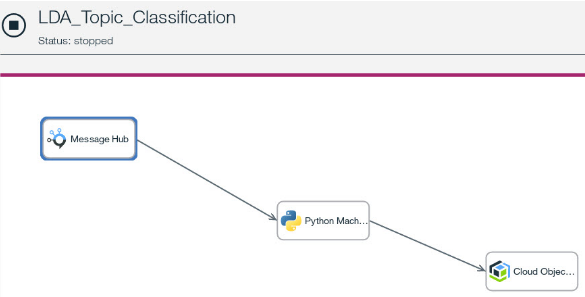

You will notice the red mark on the Notifications (bell) icon on the right, since you have to adapt the flow for your credentials and other service details.  

Select the **_Edit the streams flow_** (pencil) icon on the top right.

### Modify the flow to use your service credentials and details.

You will need to modify the flow to use your service credentials and details.  
Click on the Notifications icon to resolve the errors.
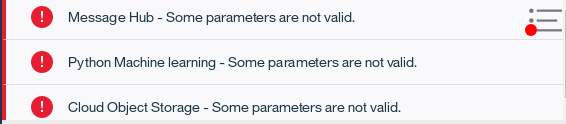

* Message Hub operator: Select your Message Hub service and choose your topic (e.g., _newsData_).
* Python Machine Learning operator: Point the File Reference Name **model** to your model file.
    - Select your COS service
    - In the **File path** field, use the **Select data asset** button on the right to select the LDA model package. In our example it's __*pyml/LDA_news.model.pkg.gz*__.
* Cloud Object Storage operator: 
    - Select your COS service
    - In the **File path** field, enter the file pattern to use for the output files. You can use the **Select data asset** button to choose an existing bucket for the output, but this will erase the sample file name provided. You can simply paste it back: __*LDA_news.topics.%TIME.csv*__

When all of the "errors" have been resolved, **_save_** your flow, and hit **_Run_**.

<a id="send"></a>
## 3. [Stream the news texts to Message Hub](#TOC)  
.  
<font color=red>Wait for your _Streams Flow_ to be in the **_running_** state before proceeding...</font>

### Create the Message Hub producer

In [3]:
# INSERT YOUR MESSAGE HUB CREDENTIALS
mh_credentials = {
    "user": "<REPLACE>",
    "password": "<REPLACE>"
}
# m9
mh_credentials = {
  "instance_id": "b32d208f-fbdb-425c-95d3-5b00b56209c4",
  "mqlight_lookup_url": "https://mqlight-lookup-prod02.messagehub.services.us-south.bluemix.net/Lookup?serviceId=b32d208f-fbdb-425c-95d3-5b00b56209c4",
  "api_key": "u4cbPZKOoOHI9uZ5J66JaZBtOF2cRVPYu4UEAG7PXIn4SleB",
  "kafka_admin_url": "https://kafka-admin-prod02.messagehub.services.us-south.bluemix.net:443",
  "kafka_rest_url": "https://kafka-rest-prod02.messagehub.services.us-south.bluemix.net:443",
  "kafka_brokers_sasl": [
    "kafka01-prod02.messagehub.services.us-south.bluemix.net:9093",
    "kafka03-prod02.messagehub.services.us-south.bluemix.net:9093",
    "kafka04-prod02.messagehub.services.us-south.bluemix.net:9093",
    "kafka02-prod02.messagehub.services.us-south.bluemix.net:9093",
    "kafka05-prod02.messagehub.services.us-south.bluemix.net:9093"
  ],
  "user": "u4cbPZKOoOHI9uZ5",
  "password": "J66JaZBtOF2cRVPYu4UEAG7PXIn4SleB"
}
mh_topic = "newsData"

mh_producer = create_messagehub_producer( mh_credentials)

username= u4cbPZKOoOHI9uZ5
password= J66JaZBtOF2cRVPYu4UEAG7PXIn4SleB
security_protocol= SASL_SSL
sasl_mechanism= PLAIN
kafka_brokers_sasl= ['kafka01-prod02.messagehub.services.us-south.bluemix.net:9093', 'kafka03-prod02.messagehub.services.us-south.bluemix.net:9093', 'kafka04-prod02.messagehub.services.us-south.bluemix.net:9093', 'kafka02-prod02.messagehub.services.us-south.bluemix.net:9093', 'kafka05-prod02.messagehub.services.us-south.bluemix.net:9093']


### Send all of the text data to the MH topic

In [9]:
import time

print(mh_topic)
data = read_dataset(dataset + ".gz")
for i, entry in enumerate(data):
    rc = mh_producer.send( mh_topic, { 'text': entry } )
    if ((i+1) % 1000) == 0:
        print(i+1, end=" ")
        time.sleep(1) # Slow things down during demo

newsData
opening... 20-newsgroups.gz
18846 lines read
1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 

# STOP HERE

In [ ]:
def mh_consumer_rest(credentials):
    import requests
    import json

    consumerInstance = 'instance1'
    consumerGroup = 'group1'

    authToken = credentials['api_key']
    kafkaRestUrl = credentials['kafka_rest_url']


    headers = {'X-Auth-Token': authToken, 'Content-Type': 'application/vnd.kafka.v1+json'}
    body1 = json.dumps({
    'name': consumerInstance,
    'format': 'binary',
    'auto.offset.reset': 'smallest'
    })
    
    response = requests.post(kafkaRestUrl + "/consumers/" + consumerGroup, data=body1, headers=headers)

    print(response.status_code, response.reason, response.text)
    result = response.json()
    print(result)
    consumerUrl = result['base_uri']
    print(consumerUrl)
    
    return consumerUrl
    
def save_to_cos( cred, bucket_name, object_name, data):
    import requests

    default_iam_url = 'https://iam.ng.bluemix.net/oidc/token'
    default_endpoint = 'https://s3-api.us-geo.objectstorage.service.networklayer.com'
    # Check for credentials or arguments. A StopIteration error means that a valid key was not found.
    api_key = next((n for n in [cred.get('apikey'), cred.get('api_key'), cred.get('IBM_API_KEY_ID')] if n is not None))
    iam_url = next((n for n in [cred.get('iam_url'), cred.get('IBM_AUTH_ENDPOINT')] if n is not None), default_iam_url)
    endpoint = next((n for n in [cred.get('url'), cred.get('ENDPOINT')] if n is not None), default_endpoint)
    
    full_object_path = bucket_name + "/" + object_name
    print("Saving", full_object_path, "(", str(len(data)), "bytes)")

    response = requests.post(
                url = iam_url,
                headers = {"Content-Type": "application/x-www-form-urlencoded"},
                params = {"grant_type":"urn:ibm:params:oauth:grant-type:apikey","apikey":api_key},
                verify = True)
    if str(response) != "<Response [200]>":
        print( "ERROR: POST Response =", response)
        return

In [ ]:
mh_credentials = {
  "instance_id": "b32d208f-fbdb-425c-95d3-5b00b56209c4",
  "mqlight_lookup_url": "https://mqlight-lookup-prod02.messagehub.services.us-south.bluemix.net/Lookup?serviceId=b32d208f-fbdb-425c-95d3-5b00b56209c4",
  "api_key": "u4cbPZKOoOHI9uZ5J66JaZBtOF2cRVPYu4UEAG7PXIn4SleB",
  "kafka_admin_url": "https://kafka-admin-prod02.messagehub.services.us-south.bluemix.net:443",
  "kafka_rest_url": "https://kafka-rest-prod02.messagehub.services.us-south.bluemix.net:443",
  "kafka_brokers_sasl": [
    "kafka01-prod02.messagehub.services.us-south.bluemix.net:9093",
    "kafka03-prod02.messagehub.services.us-south.bluemix.net:9093",
    "kafka04-prod02.messagehub.services.us-south.bluemix.net:9093",
    "kafka02-prod02.messagehub.services.us-south.bluemix.net:9093",
    "kafka05-prod02.messagehub.services.us-south.bluemix.net:9093"
  ],
  "user": "u4cbPZKOoOHI9uZ5",
  "password": "J66JaZBtOF2cRVPYu4UEAG7PXIn4SleB"
}

mh_topic = "newsData"

In [ ]:
def send_to_mh(cred, kafkaTopic, data): #value_serializer=lambda v: json.dumps(v).encode('utf-8')):
    import requests
    import json
#    import binascii

    kafka_rest_url = cred.get('kafka_rest_url', 'https://kafka-rest-prod02.messagehub.services.us-south.bluemix.net:443')
    #formatted_data = json.dumps({'records': [{'value':binascii.hexlify(b"some text").decode('utf-8')}]}, ensure_ascii=False).encode('utf8')
    #formatted_data = json.dumps({'records': [{'value':binascii.hexlify(json.dumps(data).encode('utf8')).decode('utf-8')}]}, ensure_ascii=False).encode('utf8')
    formatted_data = json.dumps({'records': [{'value': json.dumps(data).encode('utf8').decode('utf8')}]}, ensure_ascii=False).encode('utf8')

#    print(formatted_data)

    response = requests.post(url = kafka_rest_url + "/topics/" + kafkaTopic,
                             headers = {'X-Auth-Token': cred['api_key'], 'Content-Type': 'application/vnd.kafka.v1+json'},
                             data = formatted_data)

    if response.status_code != 200:
        print( "ERROR: POST Response =", response.status_code, response.reason, response.text)
        return

    return response

import json

#d = json.dumps({'records': [{'value':binascii.hexlify(b"some text").decode('utf-8')}]}, ensure_ascii=False).encode('utf8')
d = {'text': 'some more text'}
print(d)
send_to_mh(mh_credentials, mh_topic, d)

In [ ]:
import time

data = read_dataset(dataset + ".gz")
for i, entry in enumerate(data[:5000]):
    send_to_mh(mh_credentials, mh_topic, { 'text': entry } )
    if ((i+1) % 1000) == 0:
        print(i+1, end=" ")
        time.sleep(1) # Slow things down during demo

In [ ]:
def send_records_to_mh(cred, kafkaTopic, records): #value_serializer=lambda v: json.dumps(v).encode('utf-8')):
    import requests
    import json

    kafka_rest_url = cred.get('kafka_rest_url', 'https://kafka-rest-prod02.messagehub.services.us-south.bluemix.net:443')
    formatted_data = json.dumps({'records': records}, ensure_ascii=False).encode('utf8')

    response = requests.post(url = kafka_rest_url + "/topics/" + kafkaTopic,
                             headers = {'X-Auth-Token': cred['api_key'], 'Content-Type': 'application/vnd.kafka.v1+json'},
                             data = formatted_data)

    if response.status_code != 200:
        print( "ERROR: POST Response =", response.status_code, response.reason, response.text)
        return

    return response

In [ ]:
import time
import json

data = read_dataset(dataset + ".gz")
records = []
for i, entry in enumerate(data[:5000]):
    records.append({'value': json.dumps({'text': entry}).encode('utf8').decode('utf8')})
#    send_to_mh(mh_credentials, mh_topic, { 'text': entry } )
    if ((i+1) % 1000) == 0:
        print(i+1, end=" ")
        send_records_to_mh(mh_credentials, mh_topic, records )
        records = []
        time.sleep(1) # Slow things down during demo